## Calculate scaling factor to put a and b on same scale
This version runs on intcorr output from Xgremlin.
Using all lines above given SNR, regardless of identification

In [1]:
file1 = "Fe042122a.008.intcorr"
file2 = "Fe042122b.008.intcorr"
SNR = 100

Mean: 0.7118 Std. Dev: 0.0260 from 59 values; 0 outliers rejected



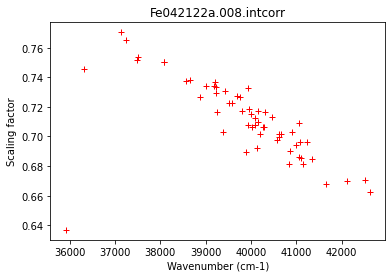

In [2]:
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt

afile = open(file1)
bfile = open(file2)

wnum=[]
inten=[]
wnumplot = []
ratio_ab = []

def reject_outliers(data):
    return data[abs(data - np.mean(data)) < 3 * np.std(data)]

for line in afile:
    line=line.split()
    if line[0].isnumeric():
        if float(line[2]) > SNR :
            wnum.append(float(line[1]))
            inten.append(float(line[5]))

for line in bfile:
    line=line.split()
    if line[0].isnumeric():
        if float(line[2])> SNR:
            wnumb = float(line[1])
            intenb = float(line[5])
            for i in wnum:
                if -0.2< wnumb-i <0.2:
                    inten_ratio = inten[wnum.index(i)]/intenb
                    wnumplot.append(wnumb)
                    ratio_ab.append(inten_ratio)
#                    print( "%10.4f %6.4f " % (wnumb, inten_ratio))


data_rej = reject_outliers(np.array(ratio_ab))
scale_mean = np.mean(data_rej)
scale_std = np.std(data_rej)
print ("Mean: %6.4f Std. Dev: %6.4f from %d values; %d outliers rejected\n" % (scale_mean, scale_std, len(data_rej), len(ratio_ab)-len(data_rej) ))

fig,ax=plt.subplots()
ax.plot(wnumplot,ratio_ab,'r+')
ax.set(xlabel="Wavenumber (cm-1)",ylabel = "Scaling factor",title = file1)
plt.rcParams["figure.figsize"] = (10,5)
plt.show()


There is a slope on the plot, with the scaling factor changing by about 13% across this region. This should be OK. 
Changing the SNR from 100 to 10 changes the mean to 0.70+-0.05 from 172 values.

## Look at the calibrations

In [3]:
D2a = open("../data/21-Apr-2022/D2042122a.2&3_response")
D2b = open("../data/21-Apr-2022/D2042122b.2&3_response")
awnum = []
bwnum = []
ainten = []
binten = []

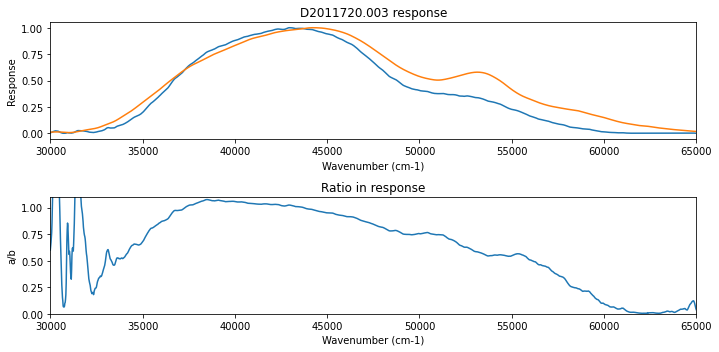

In [4]:

for line in D2a:
    line = line.split()
    if line[0] == '!':
        continue
    awn = float(line[0])
    aint = float(line[1])
    awnum.append(awn)
    ainten.append(aint)
        
for line in D2b:
    line = line.split()
    if line[0] == '!':
        continue
    bwn = float(line[0])
    bint = float(line[1])
    bwnum.append(bwn)
    binten.append(bint)   

abratio = np.divide(ainten, binten)
        
figa,axa=plt.subplots(2,1)
axa[0].plot(awnum,ainten,bwnum,binten)
axa[0].set(xlabel="Wavenumber (cm-1)",ylabel = "Response",title = "D2011720.003 response")
axa[0].set_xlim(30000,65000)

axa[1].plot(awnum,abratio)
axa[1].set(xlabel="Wavenumber (cm-1)",ylabel = "a/b",title = "Ratio in response")
axa[1].set_xlim(30000,65000)
axa[1].set_ylim(0.,1.1)

plt.rcParams["figure.figsize"] = (10,10)
figa.tight_layout()
plt.show()


### Scale detector B to detector A and combine the two detectors using weighted mean

In [5]:
import numpy as np

afile = open("Fe042122a.008.intcorr")
bfile = open("Fe042122b.008.intcorr")
outfile = open("Fe042122.008.combined",'w')

wnum=[]
inten=[]
wt=[]
outline=[]
fwhm=[]

# print("Scaling factor: ",scale_mean)
# print("Wavenumber     SNR     FWHM    Inten")

for line in afile:
    line=line.split()
    if line[0].isnumeric():
        wnum.append(float(line[1]))
        inten.append(float(line[5]))
        wt.append(min(10000,(float(line[2])**2)))  # Set max. SNR of 100
        fwhm.append(line[3])

prt=0
for line in bfile:
    line=line.split()
    if line[0].isnumeric():
        wnumb = float(line[1])
        intenb = scale_mean*float(line[5])
        mtc=0

        for i in wnum:
            if -0.2< wnumb-i <0.2:
                mtc=1
                idx=wnum.index(i)
                weight=min(10000,float(line[2])**2)  # Set max. SNR of 100
                awt=wt[wnum.index(i)]                # Weight from detector A
                
                aveinten=np.average([intenb,inten[idx]],weights=(weight,awt))   #Weighted mean intensity
# Calculate standard deviation based on minimum of next two functions. See Liggins, ApJS 252, 10 for details.             
                std1=np.sqrt(np.average(((intenb-aveinten)**2,(inten[idx]-aveinten)**2), weights=(weight,awt)))
                std2=aveinten/np.sqrt(weight+awt)
                stdinten=max(std1,std2)
#                print("%10.4f %6d %6d   %6d %6.0f  " %(wnumb,intenb,inten[idx],aveinten,aveinten/stdinten))
                outline.append((wnumb,aveinten/stdinten,line[3],aveinten))
                prt+=1
# Delete the ones we've used
                del inten[idx]
                del wt[idx]
                del wnum[idx]
                del fwhm[idx]

# Add the ones from detector B that didn't match to the output array
        if mtc==0:
#            print("%10.4f        %6d            %4.0f" %(wnumb,intenb,min(100,float(line[2]))))
            outline.append((wnumb,min(100,float(line[2])),line[3],intenb))
            prt+=1

        # And then the ones from detector A that didn't match - the ones left after deleting the matching ones
for i in wnum:
    idx=wnum.index(i)
#    print("%10.4f %6d                   %4.0f" %(i,inten[idx],min(100,wt[idx])))
    outline.append((i,min(100,np.sqrt(wt[idx])),fwhm[idx],inten[idx]))
    prt+=1
outline.sort()

# Write the lines out to the new .intcorr file
n=0
for i in outline:
#    print ("%10.4f     %3d     %4d  %7d" % ( i[0],i[1],float(i[2]),i[3]))
    outfile.write("%3d %10.4f     %3d     %4d   - %7d\n" % ( n,i[0],i[1],float(i[2]),i[3]))
    n+=1

outfile.close()

### Now match everything up to identifications

In [6]:
import math
 
brfile= open("Fe042122.008.combined")
outfile= open("Fe042122c.008.II",'w')
idfile = open("FeII.GN")

resoln = 0.1
wlow = 33000.
whi = 60000.

In [7]:
outfile.write("%s %s %s\n" % (resoln, wlow, whi))

idlow=[]
elow=[]
idupp=[]
eupp=[]
wl=[]

for line in idfile:
    line=line.split()
    idlow.append(line[6])
    elow.append(line[6])
    idupp.append(line[7])
    eupp.append(line[7])

    wl.append(line[4])

for line in brfile:
  line=line.split()
  if str.isdigit(line[0]):
    wno = float(line[1])
    snr = line[2]
    fwhm = line[3]
    inten = line[5]
#    wlen = float(line[15])*10.
    wlen = 1e8/wno
#    print(wno,snr,fwhm,inten)
    for wavel in wl:
        if -0.25  < float(wavel) - wno < 0.25 :
            idl = idlow[wl.index(wavel)]
            idu = idupp[wl.index(wavel)]
            outfile.write("%-5.0f %6.0f  %7.2f %8.3f  %10.3f   II   %s - %s\n" % (float(snr),float(inten),float(fwhm),wlen,wno,idl,idu))

outfile.close()


## Calculate the wavenumber correction factors

Mean: -1.99e-06 +- 1.85e-08 from 62 values; 1 outliers rejected



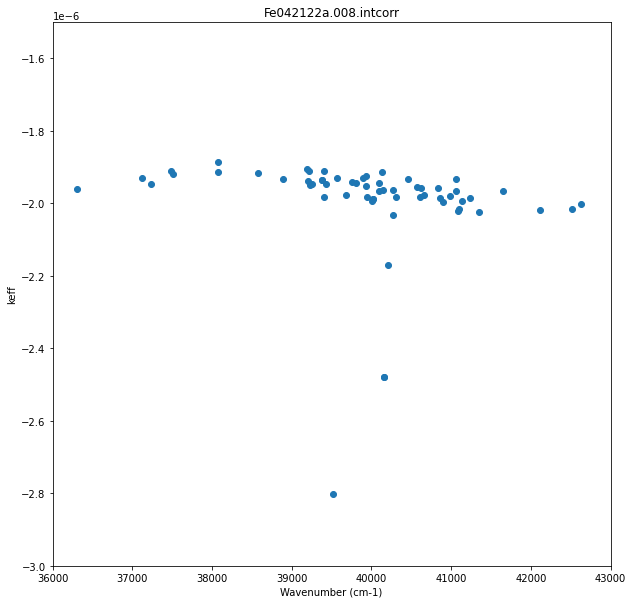

In [8]:
import numpy as np
import matplotlib.pyplot as plt

file1="Fe042122a.008.intcorr"
afile = open(file1)
calfile = open("fe.wcal")

def reject_outliers(data):
    return data[abs(data - np.mean(data)) < 3 * np.std(data)]

wl=[]
wlen = []
wdiff=[]

for line in calfile:
    line=line.split()
    wl.append(float(line[0]))
        
for line in afile:
    line=line.split()
    try:
        wsig = float(line[1])
    except:
        continue
#    print (wsig,float(line[2]))
    if float(line[2]) > 100:
        for i in wl:
            if -0.25 < wsig-i < 0.25:
                wlen.append(wsig)
                wdiff.append((wsig-i)/wsig)
        
data_rej = reject_outliers(np.array(wdiff))
scale_mean = np.average(data_rej)#,weights=wt)
scale_std = np.std(data_rej)/np.sqrt(len(wdiff))
print ("Mean: %6.2e +- %6.2e from %d values; %d outliers rejected\n" % (scale_mean, scale_std, len(wdiff), len(wdiff)-len(data_rej) ))

plt.axes(ylim=[-3e-6,-1.5e-6],xlim=[36000,43000])
plt.scatter(wlen,wdiff)
plt.xlabel("Wavenumber (cm-1)")
plt.ylabel("keff")
plt.title(file1)
plt.show()

Mean: -2.86e-06 +- 1.59e-08 from 79 values; 1 outliers rejected



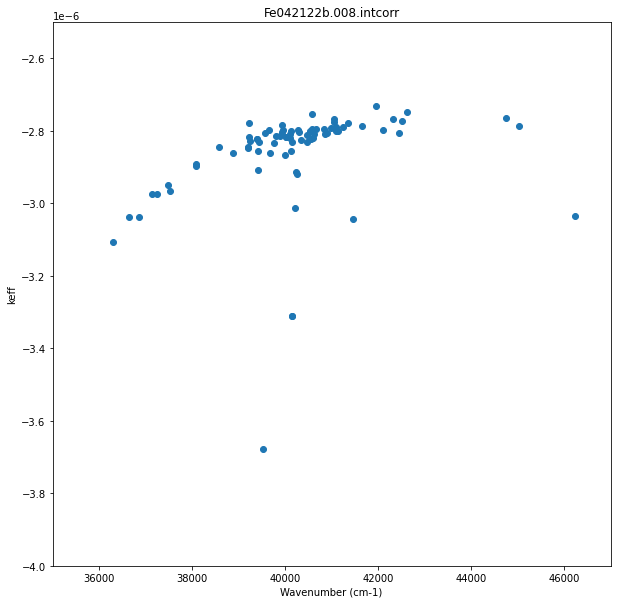

In [9]:
import numpy as np
import matplotlib.pyplot as plt

file1="Fe042122b.008.intcorr"
afile = open(file1)
calfile = open("fe.wcal")

def reject_outliers(data):
    return data[abs(data - np.mean(data)) < 3 * np.std(data)]

wl=[]
wlen = []
wdiff=[]

for line in calfile:
    line=line.split()
    wl.append(float(line[0]))
        
for line in afile:
    line=line.split()
    try:
        wsig = float(line[1])
    except:
        continue
#    print (wsig,float(line[2]))
    if float(line[2]) > 100:
        for i in wl:
            if -0.25 < wsig-i < 0.25:
                wlen.append(wsig)
                wdiff.append((wsig-i)/wsig)
        
data_rej = reject_outliers(np.array(wdiff))
scale_mean = np.average(data_rej)#,weights=wt)
scale_std = np.std(data_rej)/np.sqrt(len(wdiff))
print ("Mean: %6.2e +- %6.2e from %d values; %d outliers rejected\n" % (scale_mean, scale_std, len(wdiff), len(wdiff)-len(data_rej) ))

plt.axes(ylim=[-4e-6,-2.5e-6],xlim=[35000,47000])
plt.scatter(wlen,wdiff)
plt.xlabel("Wavenumber (cm-1)")
plt.ylabel("keff")
plt.title(file1)
plt.show()